In [2]:
import sys
import glob
import freqCal_auto as FC # import this
import time
import extractTemperature_auto as ET
import matplotlib.pyplot as plt
import numpy as np
import xlrd
import pandas as pd

from scipy import interpolate
import definitions as defs
from elecsus.libs import numberDensityEqs as n
from scipy.constants import physical_constants, c

In [3]:
kB=physical_constants['Boltzmann constant'][0] 
amu=physical_constants['atomic mass constant'][0] #An atomic mass unit in kg


GHz = 1e9
MHz = 1e6
t0 = time.time()

In [4]:
# date_stamp = '20230928'
# target_timestamp = "od-cellTemp116"
# main_folder = 'datafolder'
# path = main_folder +'/' + date_stamp +'/'
# format = 'csv'
# all_files = glob.glob(path + f"*{format}")
# all_files.sort()
# try:
#     files = FC.getTargetData(target_timestamp,all_files) # calling a function in FC to get the file you care about
#     files = files[-1:][0] # get the no pumping case
# except:
#     sys.exit('Error. Check filename, date and timestamp.')

In [5]:
date_stamp = '20220412'
target_timestamp = "20220412_163417_temperature"
main_folder = 'datafolder'
path = main_folder +'/' + date_stamp +'/'
format = 'xls'
all_files = glob.glob(path + f"*{format}")
all_files.sort()
try:
    files = FC.getTargetData(target_timestamp,all_files) # calling a function in FC to get the file you care about
    files = files[-1:][0] # get the no pumping case
except:
    sys.exit('Error. Check filename, date and timestamp.')

In [6]:
# pd = pd.read_excel(files)

In [7]:
smoothFlag = 1 # 0 for raw data, 1 for smoothed data    
plotFlag = 0 # 1 for yes, 0 for no
cellFlag = 1 # 0 for ref cell, 1 for memory cell

In [8]:
# done this as there are these two options in the soton lab. Either you use the ref cell which has natural abundance, of the memory cell which is pure Rb87
# can just do these by hand in the function below
if(cellFlag==1):
    RB85frac = 0 # in percentage
    L = 0.08 # length of cell
elif(cellFlag==0):
    RB85frac = 72.17 # in percentage
    L = 0.08 # length of cell
else:
    sys.exit('Try again')

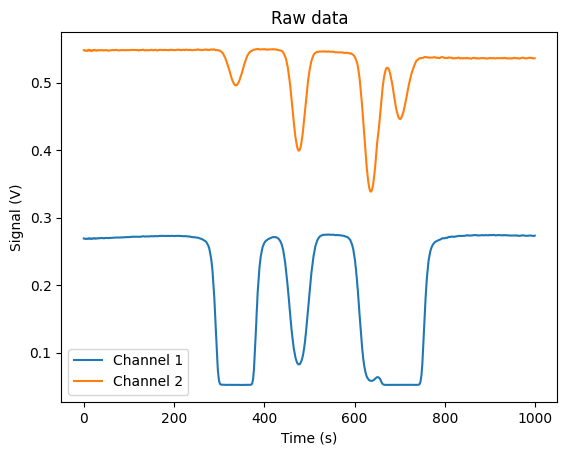

[337 477 636 701]


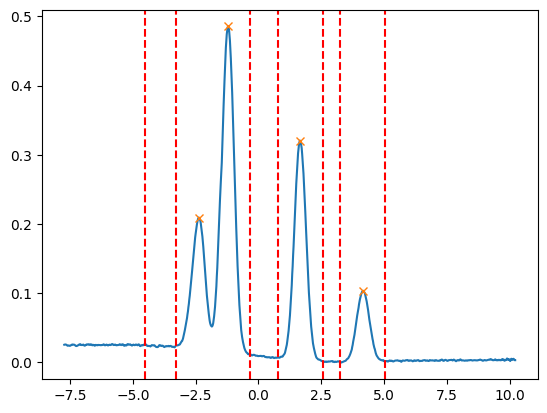

In [9]:
# using a function in FC to get the time data, chan1  and chan3. Smooth flag is there is indicate if you want smoothing or not 
time_data, chan1, chan2 = FC.readDataICL(files, smoothFlag, format) 


# Crop data 

crop_start = int(0/100 * len(time_data))
crop_end = int(100/100 * len(time_data))

time_data = time_data[crop_start:crop_end]
chan1 = chan1[crop_start:crop_end]
chan2 = chan2[crop_start:crop_end]
# chan3 = chan3[crop_start:crop_end]

# Reverse order of data
# time_data = time_data[::-1]
# chan1 = chan1[::-1]
# chan2 = chan2[::-1]
# chan3 = chan3[::-1]



# Plot data
plt.figure()
plt.plot(time_data,chan1)
plt.plot(time_data,chan2)
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.title('Raw data')
plt.legend(['Channel 1','Channel 2'])
plt.show()


#%%
temp_init = 70
temp_Dopp = 120
Constrain = False # choose true to have the temp and Doppler temp constrained, false to have as independent parameters

# calling a function in FC to calibrate the frequency axis. This does a basic calibration using the four dips of the reference cell, 
# then recalibrates by fitting a function from elecsus. You can choose to plot the fit, and which cell to use for this, see above.
[freq, residuals, temperature, temp_Doppler, RbFrac, popt] , [data_signal,_fit,residual, rms, res_max]= \
    FC.frequencyCalibrate(time_data,chan1,chan2, RB85frac, L, temp_init, temp_Dopp, plotFlag, cellFlag, Constrain, prominence=0.03, distance=50) 

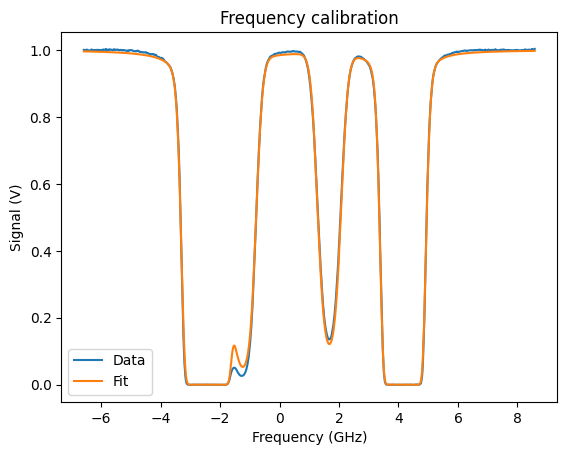

In [9]:
# Plot freq against data_signal and _fit
plt.figure()
plt.plot(freq,data_signal)
plt.plot(freq,_fit)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Signal (V)')
plt.title('Frequency calibration')
plt.legend(['Data','Fit'])
plt.show()


In [10]:
print(rms)

0.00011708554499577129


In [19]:
print('Temp (Atom Number) =',temperature,'°C')
if(Constrain):
    pass
else:
    print('Temp (Doppler) =',temp_Doppler,'°C')
print('Rb85|Rb87:',RbFrac,'|',round(100-RbFrac,2))

Temp (Atom Number) = 103.65 °C
Temp (Doppler) = 200.0 °C
Rb85|Rb87: 12.5 | 87.5


In [20]:
t1 = time.time()
total = t1-t0
print('Time taken = ',round(total,2),'s')

Time taken =  486.96 s


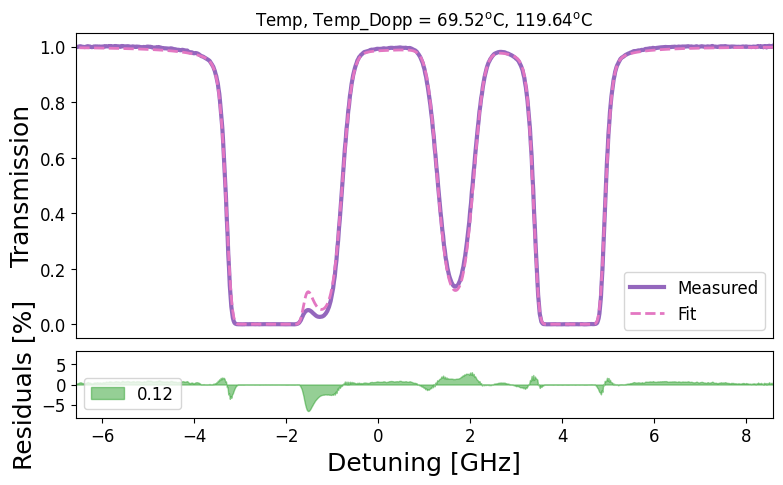

In [36]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

n_Dopp = FC.getDensity(temp_Doppler)
n_OD = FC.getDensity(temperature)

gamma = 38.11e6
c = 299792458
hbar = 1.05457182e-34
trans_dipole = 3.584e-29
e0 = 8.8541878128e-12
lambd = 780.241209686e-9

L = 8e-2
omega =  2*np.pi*384.2304844685e12
sigma_cross = trans_dipole**2*omega/(2*e0*c*gamma*hbar)
# sigma_cross = 3*(lambd**2)/(2*np.pi)
d = n_OD*sigma_cross*L

fu=max(freq)
fl=min(freq)


x = np.arange(0, len(freq));y = freq;f = interpolate.interp1d(x, y)
xnew = np.arange(0, len(freq)-1, 0.1); ff = f(xnew)
[f0,f1,f2,f3] = [popt[0],popt[1],popt[2],popt[3]]


nat_abund = 72.17
temps = [-5, -273.14]

ff87L = ff[np.where(ff<-1.8)];ff87H = ff[np.where(ff>2.9)]
ff85 = ff[np.where(np.logical_and(ff>-1.8, ff<2.9))]
roomTemp87_L = ET.getTransRecal(ff87L,f0,f1,f2,f3,nat_abund,temps[0],temps[1])
roomTemp87_H = ET.getTransRecal(ff87H,f0,f1,f2,f3,nat_abund,temps[0],temps[1])
roomTemp85 = ET.getTransRecal(ff85,f0,f1,f2,f3,nat_abund,temps[0],temps[1])

roomTemp = ET.getTransRecal(ff,f0,f1,f2,f3,nat_abund,20,20)


cnt = 0
save_em=0
if(1):
    with plt.style.context('_classic_test_patch'):
        fig3 = plt.figure(2, figsize=(9, 5))
        plt.cla()
        plt.clf()
        grid = plt.GridSpec(5,1,hspace=0.2)
        main_ax = fig3.add_subplot(grid[0:4])
        res_ax = fig3.add_subplot(grid[4])
        
        # main_ax.plot(ff87L,roomTemp87_L,'-',linewidth=1,color=ET.cc('tab:blue',1),label='Rb87')
        # main_ax.plot(ff87H,roomTemp87_H,'-',linewidth=1,color=ET.cc('tab:blue',1))
        # main_ax.plot(ff85,roomTemp85,'-',linewidth=1,color=ET.cc('tab:orange',1),label='Rb85')
        
        # main_ax.plot(ff,roomTemp,'-',linewidth=3,color=ET.cc('tab:red',1))
        
        main_ax.plot(freq,data_signal,'-',linewidth=3,color=ET.cc('tab:purple',1),label='Measured')
        main_ax.plot(freq,_fit,'--',linewidth=2,color=ET.cc('tab:pink',1),label='Fit')
        main_ax.set_title(r'Temp, Temp_Dopp = %.2f$^\mathrm{o}$C, %.2f$^\mathrm{o}$C' % (temperature, temp_Doppler))

        
        
        main_ax.set_xlim([fl,fu])
        main_ax.set_ylim([-0.05,1.05])
        main_ax.set_xticks([])
        main_ax.set_ylabel('Transmission')
        main_ax.legend(loc="lower right")
        
        
        res_ax.fill_between(freq,residual,color=ET.cc('tab:green',0.5),label=r'%.2f' % residuals)
        res_ax.set_ylim(np.asarray([-res_max,res_max])*1.25)
        res_ax.set_xlim([fl,fu])
        res_ax.set_ylabel('Residuals [%]')
        res_ax.set_xlabel('Detuning [GHz]')
        res_ax.legend(loc="lower left")

        cnt+=1
        if(save_em):plt.savefig('figs/Specturm' + date_stamp + '_' + target_timestamp +'_Temp'+ str(temp_Doppler*100)[:-2]+'_'+str(cnt)+'.png', format='png', dpi=500, bbox_inches="tight")



In [25]:
Gamma_D2 = 6.065e6
trans_dipole_D2 = 3.584e-29
Wav_D2 = 780.241209686e-9
f = 300e-3; w_i = 1e-3/2; waist = Wav_D2*f/(np.pi*w_i)
num_density = n.CalcNumberDensity(temperature+273.15,'Rb87')*(1-RbFrac/100)
vol = defs.getVol(waist,L,Wav_D2)
N = num_density*vol

OD = defs.OD(trans_dipole_D2,Wav_D2,N,waist,Gamma_D2)
mass = 86.909180520*amu
a = np.sqrt(kB*(temp_Doppler+273.15)/mass)
U = np.sqrt(2)*a


f0 =384230426.6e6
DoppBroad = f0*np.sqrt(8*kB*(temp_Doppler+273.15)*np.log(2)/(mass*c**2))

# U = np.sqrt(a**2*(3*np.pi - 8)/np.pi)
print('OD = ' + str(OD))
print('Number of Atoms = ' + str(np.round(N/1e9,1)) + ' x 10^9')
print('Dopp. Broad. = ' + str(np.round(1e-6*DoppBroad,2)) + ' MHz')

OD = 788.8837564637901
Number of Atoms = 0.4 x 10^9
Dopp. Broad. = 642.11 MHz


In [26]:
m=1;
cm=1e-2;
temp = 80 

num = n.CalcNumberDensity(temp+273.15,'Rb87')/(m**3/cm**3)
alpha=6.5e-10
us=1e-6

print(str(round(num*alpha,2))+'Hz')
print(str(round(1/(num*alpha)/us,2))+'us')



1006.73Hz
993.31us
